In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import spacy
import pickle
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim
from gensim.utils import simple_preprocess

from pprint import pprint

In [4]:
aita_all = pd.read_csv("datasets/aita_dataset.csv")

In [5]:
aita_all.head()

,Unnamed: 0,id,timestamp,title,body,verdict,score
0,0,1ytxov,1393278651,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,asshole,52
1,1,1yu29c,1393281184,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",asshole,140
2,2,1yu8hi,1393284677,I told a goth girl she looked like a clown.,I was four.,not the asshole,74
3,3,1yuc78,1393286728,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,everyone sucks,22
4,4,1yueqb,1393288164,[AITA] I let my story get a little long and bo...,NaN,not the asshole,6


In [ ]:
aita_all["post"] = aita_all["title"] +" " +aita_all["body"]

In [ ]:
aita_all["post"] = aita_all["post"].astype('string')

In [ ]:
aita_all.dropna(inplace = True)

## Utils

### Data cleaning

In [ ]:
def remove_links(text):
    return re.sub(r'http\S+', '', text)
def make_lower(text):
    return text.lower()
def remove_digits(text):
    return re.sub('\d', ' ', text)
def remove_punctuation(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    return re.sub(r'[^\w\s]', ' ', text)
def remove_extraspaces(text):
    return re.sub('\s\s+',' ', text)
def clean_text(text):
    text = remove_links(text)
    text = make_lower(text)
    text = remove_digits(text)
    text = remove_extraspaces(text)
    text = remove_punctuation(text)
    return text


In [1]:
def lemmatize_text(text):
    text = sp(text)
    tokenised_text = [word.lemma_ for word in text]
    return ' '.join(tokenised_text)
def remove_stopwords(text):
    tokenised_text = text.split()
    tokenised_text = [word for word in tokenised_text if word not in stopwords]
    return ' '.join(tokenised_text)

### Sentiment analysis

In [ ]:
def add_polarity_scores(df):
  df["Polarity scores"] =  df['post_clean'].apply(lambda post: sia.polarity_scores(post))
  return df

### Topic modelling

In [ ]:
def get_texts_id2word_corpus(posts): # create the texts, id2word and corpus lists 
    texts = [gensim.utils.simple_preprocess(str(post)) for post in posts]
    id2word = gensim.corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    return texts, id2word, corpus

In [ ]:
def compute_coherence_values(lda, corpus, texts, limit,id2word, start=2, step=3):  # This code has been adapted from the following blog: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
    coherence_values = []
    models = []
    for num_topics in range(limit, start, step):
        print(num_topics)
        if lda == "multicore":
          model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        elif lda=="mallet":
          model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        models.append(model)
        print("MALLET MODEL ADDED: ", models)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print("COHERENCE VALUE ADDED: ", coherence_values)

    return models, coherence_values

In [ ]:
def plot_coherence_values(coherence_values, coherence_values_multicore):
  limit=40
  start=10
  step=-6
  x = range(limit, start, step)
  plt.plot(x, coherence_values, '--bo', label = "LdaMallet", color="green")
  plt.plot(x, coherence_values_multicore, '--bo', label = "LdaMulticore", color="red")
  plt.legend()
  plt.xlabel("Num Topics")
  plt.ylabel("Coherence score")
  plt.show()

## Preprocessing 

### Data cleaning

In [ ]:
aita_all["post_clean"] = aita_all["post"].apply(lambda x:clean_text(x)) # basic cleaning

In [ ]:
sp = spacy.load('en_core_web_sm')
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
aita_all["post_clean"] = aita_all['post_clean'].apply(lambda x:lemmatize_text(x)) # lemmatisation

In [ ]:
aita_all["post_clean"] = aita_all['post_clean'].apply(lambda x:remove_stopwords(x)) # stop-words removal

In [ ]:
remove_stopwords("I have gone to the library today to finish my dissertation")

'I gone library today finish dissertation'

## Sentiment analysis

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
aita_all = add_polarity_scores(aita_all) # add polarity scores

In [ ]:
aita_all['compound'] = aita_all["Polarity scores"].apply(lambda score_dict: score_dict['compound']) # add compound score

In [ ]:
aita_all['sentiment'] = aita_all['compound'].apply(lambda c: 'positive' if c >=0.05 else 'negative' if c <= -0.05 else 'neutral') #generate dominant sentiment

In [ ]:
aita_all.to_csv("datasets/aita_preprocessed.csv") # save pre-processed data

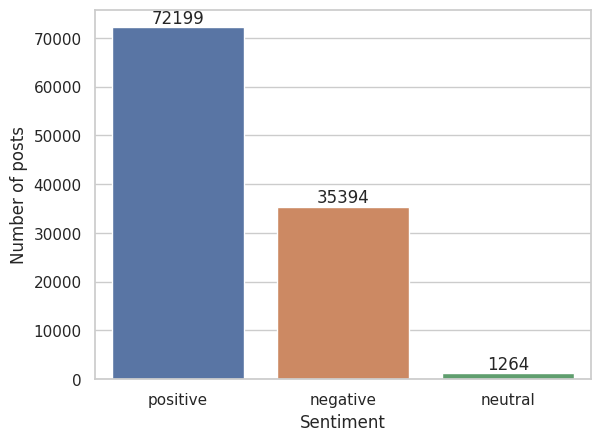

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x = "sentiment",data = aita_all)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Sentiment', ylabel='Number of posts')
plt.show()

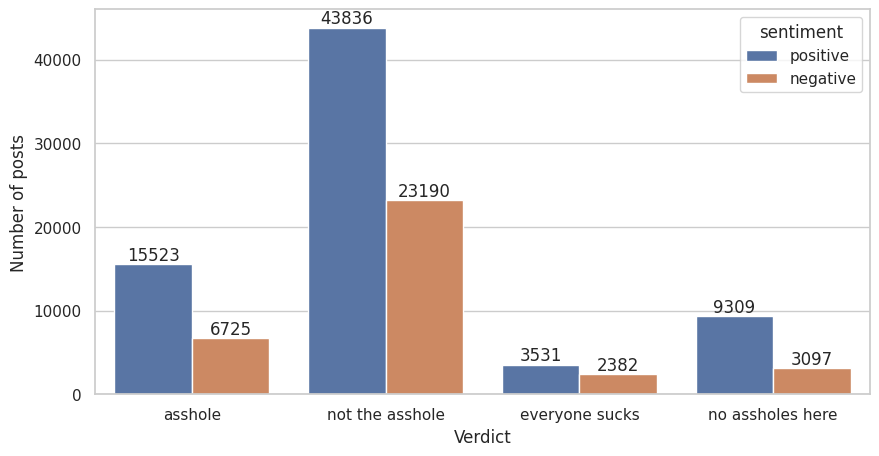

positive    72199
negative    35394
Name: sentiment, dtype: int64

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
ax = sns.countplot(x = "verdict",data = aita_all[aita_all["sentiment"]!="neutral"], hue="sentiment")
ax.set(xlabel='Verdict', ylabel='Number of posts')
ax.bar_label(container = ax.containers[0])
ax.bar_label(container = ax.containers[1])
plt.show()
aita_all[aita_all["sentiment"]!="neutral"]["sentiment"].value_counts()

## Topic modelling

### LDA Analysis preparation

In [ ]:
texts, id2word, corpus = get_texts_id2word_corpus(aita_all["post_clean"])

In [ ]:
[id2word[i] for i in range(len(id2word))], texts, corpus

(['aita',
  'asshole',
  'avoid',
  'come',
  'common',
  'condescend',
  'definitely',
  'explain',
  'explanation',
  'future',
  'help',
  'immature',
  'like',
  'little',
  'perspective',
  'possible',
  'post',
  'pretty',
  'question',
  'randomly',
  'reddit',
  'rude',
  'say',
  'seem',
  'skew',
  'something',
  'sorry',
  'think',
  'til',
  'try',
  'write'],
 [['aita',
   'write',
   'explanation',
   'til',
   'come',
   'condescend',
   'post',
   'question',
   'seem',
   'like',
   'come',
   'asshole',
   'future',
   'avoid',
   'think',
   'randomly',
   'explain',
   'something',
   'seem',
   'common',
   'reddit',
   'definitely',
   'say',
   'sorry',
   'try',
   'help',
   'pretty',
   'immature',
   'rude',
   'asshole',
   'write',
   'little',
   'possible',
   'skew',
   'perspective',
   'little',
   'possible']],
 [[(0, 1),
   (1, 2),
   (2, 1),
   (3, 2),
   (4, 1),
   (5, 1),
   (6, 1),
   (7, 1),
   (8, 1),
   (9, 1),
   (10, 1),
   (11, 1),
   (12, 

### MALLET LDA

In [ ]:
!pip install --upgrade gensim==3.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
import os
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

### Explore different topics and parameters


In [ ]:
models_multicore, coherence_values_multicore = compute_coherence_values(lda = "multicore",corpus=corpus, texts=texts,id2word = id2word, start=10, limit=40, step=-6)

40
MALLET MODEL ADDED:  [<gensim.models.ldamulticore.LdaMulticore object at 0x7f3eb8579790>]
COHERENCE VALUE ADDED:  [0.33418279929347655]
34
MALLET MODEL ADDED:  [<gensim.models.ldamulticore.LdaMulticore object at 0x7f3eb8579790>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f3eb89c3dc0>]
COHERENCE VALUE ADDED:  [0.33418279929347655, 0.3397272577052796]
28
MALLET MODEL ADDED:  [<gensim.models.ldamulticore.LdaMulticore object at 0x7f3eb8579790>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f3eb89c3dc0>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f3eab792c70>]
COHERENCE VALUE ADDED:  [0.33418279929347655, 0.3397272577052796, 0.3303108192460914]
22
MALLET MODEL ADDED:  [<gensim.models.ldamulticore.LdaMulticore object at 0x7f3eb8579790>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f3eb89c3dc0>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f3eab792c70>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f3eb8528be0>]
COHERENCE VALUE ADDED:

In [ ]:
models_mallet, coherence_values_mallet = compute_coherence_values(lda = "mallet",corpus=corpus, texts=texts,id2word = id2word, start=10, limit=40, step=-6)

40
MALLET MODEL ADDED:  [<gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f3eba086af0>]
COHERENCE VALUE ADDED:  [0.4375573671324814]
34
MALLET MODEL ADDED:  [<gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f3eba086af0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f3eabcb7df0>]
COHERENCE VALUE ADDED:  [0.4375573671324814, 0.43295161723755227]
28
MALLET MODEL ADDED:  [<gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f3eba086af0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f3eabcb7df0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f3ebdb8e940>]
COHERENCE VALUE ADDED:  [0.4375573671324814, 0.43295161723755227, 0.43625837753461083]
22
MALLET MODEL ADDED:  [<gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f3eba086af0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f3eabcb7df0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f3ebdb8e940>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7f3eabc

<ipython-input-43-8457a92d2bec>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, coherence_values, '--bo', label = "LdaMallet", color="green")
<ipython-input-43-8457a92d2bec>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, coherence_values_multicore, '--bo', label = "LdaMulticore", color="red")


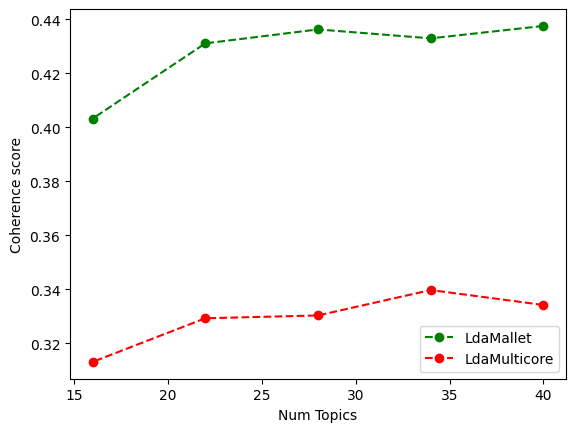

In [ ]:
plot_coherence_values(coherence_values_mallet, coherence_values_multicore)

### Optimal model

In [ ]:
lda_optimal = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=corpus, num_topics=20, id2word=id2word
)
pprint(lda_optimal.print_topics())

[(0,
  '0.065*"school" + 0.028*"college" + 0.026*"class" + 0.023*"high" + '
  '0.021*"year" + 0.015*"student" + 0.014*"aita" + 0.013*"make" + '
  '0.011*"study" + 0.011*"teacher"'),
 (1,
  '0.025*"life" + 0.025*"thing" + 0.024*"issue" + 0.017*"feel" + 0.016*"time" '
  '+ 0.014*"partner" + 0.011*"support" + 0.010*"problem" + 0.009*"lot" + '
  '0.009*"mental"'),
 (2,
  '0.146*"feel" + 0.075*"make" + 0.050*"boyfriend" + 0.035*"thing" + '
  '0.035*"upset" + 0.030*"time" + 0.026*"bad" + 0.020*"talk" + 0.019*"bf" + '
  '0.017*"aita"'),
 (3,
  '0.041*"eat" + 0.039*"food" + 0.037*"make" + 0.026*"aita" + 0.020*"dinner" + '
  '0.019*"order" + 0.014*"bring" + 0.013*"cook" + 0.013*"table" + '
  '0.012*"lunch"'),
 (4,
  '0.258*"friend" + 0.044*"girl" + 0.038*"good" + 0.037*"people" + '
  '0.034*"group" + 0.033*"talk" + 0.028*"hang" + 0.023*"close" + 0.016*"guy" + '
  '0.013*"person"'),
 (5,
  '0.125*"work" + 0.052*"job" + 0.015*"week" + 0.015*"coworker" + '
  '0.015*"company" + 0.014*"day" + 0.013*

In [ ]:
coherencemodel_optimal = CoherenceModel(model=lda_optimal, texts = texts, dictionary=id2word, coherence='c_v')
print(coherencemodel_optimal.get_coherence())

0.43184583156779005


### Get dominant topics, topic distribution and documents per topic

In [ ]:
def get_dominant_topics(df_topic_sents_keywords): # This code has been adapted from the following blog: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
    sent_topics_sorteddf_mallet = pd.DataFrame()

    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
      sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
    sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
 
    topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

    topic_contribution = round(topic_counts/topic_counts.sum(), 4)

    topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

    df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)


    df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

    df_dominant_topics.sort_values("Num_Documents",ascending = False,inplace = True)
    return df_dominant_topics

In [ ]:
def get_topic_for_document(ldamodel, corpus, texts):  # This code has been adapted from the following blog: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

    sent_topics_df = pd.DataFrame()

  
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    df_topic_sents_keywords = pd.concat([sent_topics_df, contents], axis=1)
    return df_topic_sents_keywords

In [ ]:
df_topic_sents_keywords = get_topic_for_document(ldamodel=lda_optimal, corpus=corpus, texts=texts)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [ ]:
dominant_topics = get_dominant_topics(df_topic_sents_keywords)

In [ ]:
dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
16,16,"room, dog, house, move, roommate, live, clean,...",9350,0.0859
9,9,"pay, money, buy, give, month, back, rent, bill...",7415,0.0681
6,6,"mom, family, sister, parent, dad, brother, mot...",7393,0.0679
17,17,"party, wedding, birthday, christmas, gift, inv...",7314,0.0672
18,18,"car, drive, walk, back, sit, aita, minute, fro...",6481,0.0595
3,3,"eat, food, make, aita, dinner, order, bring, c...",6172,0.0567
4,4,"friend, girl, good, people, group, talk, hang,...",5979,0.0549
5,5,"work, job, week, coworker, company, day, time,...",5908,0.0543
11,11,"kid, wife, husband, child, daughter, son, year...",5864,0.0539
14,14,"play, game, watch, aita, show, time, movie, ma...",5313,0.0488


In [ ]:
aita_all.insert(3,"Keywords",df_dominant_topic["Keywords"])

In [ ]:
aita_all.insert(3,"Topic",df_dominant_topic["Dominant_Topic"])

In [ ]:
aita_all["Keywords"].unique()

array(['call, phone, send, post, message, text, respond, picture, reply, find',
       'eat, food, make, aita, dinner, order, bring, cook, table, lunch',
       'friend, girl, good, people, group, talk, hang, close, guy, person',
       'girlfriend, relationship, date, break, year, month, talk, start, meet, ago',
       'play, game, watch, aita, show, time, movie, make, video, people',
       'day, time, home, night, hour, leave, work, week, sleep, stay',
       'room, dog, house, move, roommate, live, clean, apartment, cat, door',
       'aita, bad, sick, smoke, hair, care, day, hospital, doctor, make',
       'move, time, plan, live, week, trip, stay, month, year, place',
       'life, thing, issue, feel, time, partner, support, problem, lot, mental',
       'car, drive, walk, back, sit, aita, minute, front, wait, people',
       'start, call, talk, stop, hear, yell, apologize, cry, joke, angry',
       'guy, pretty, thing, stuff, drink, aita, bit, asshole, back, shit',
       'pay, 

In [ ]:
aita_all["Keywords"] = aita_all["Keywords"].replace('eat, food, make, aita, dinner, order, bring, cook, table, lunch',"Food")
aita_all["Keywords"] = aita_all["Keywords"].replace('party, wedding, birthday, christmas, gift, invite, family, year, wear, event',"Events")
aita_all["Keywords"] = aita_all["Keywords"].replace('play, game, watch, aita, show, time, movie, make, video, people',"Entertainment")
aita_all["Keywords"] = aita_all["Keywords"].replace('kid, wife, husband, child, daughter, son, year, baby, aita, law',"Family")
aita_all["Keywords"] = aita_all["Keywords"].replace('mom, family, sister, parent, dad, brother, mother, year, father, house',"Family")
aita_all["Keywords"] = aita_all["Keywords"].replace('school, college, class, high, year, student, aita, make, study, teacher',"Education")
aita_all["Keywords"] = aita_all["Keywords"].replace('call, phone, send, post, message, text, respond, picture, reply, find',"Communication")
aita_all["Keywords"] = aita_all["Keywords"].replace('start, call, talk, stop, hear, yell, apologize, cry, joke, angry',"Communication")
aita_all["Keywords"] = aita_all["Keywords"].replace('work, job, week, coworker, company, day, time, boss, manager, business', "Work")
aita_all["Keywords"] = aita_all["Keywords"].replace('pay, money, buy, give, month, back, rent, bill, save, card',"Finance")
aita_all["Keywords"] = aita_all["Keywords"].replace('aita, bad, sick, smoke, hair, care, day, hospital, doctor, make',"Health")
aita_all["Keywords"] = aita_all["Keywords"].replace('room, dog, house, move, roommate, live, clean, apartment, cat, door',"Housing")
aita_all["Keywords"] = aita_all["Keywords"].replace('day, time, home, night, hour, leave, work, week, sleep, stay',"TimeManagement")
aita_all["Keywords"] = aita_all["Keywords"].replace('move, time, plan, live, week, trip, stay, month, year, place',"TimeManagement")
aita_all["Keywords"] = aita_all["Keywords"].replace('life, thing, issue, feel, time, partner, support, problem, lot, mental',"Relationship")
aita_all["Keywords"] = aita_all["Keywords"].replace('feel, make, boyfriend, thing, upset, time, bad, talk, bf, aita',"Relationship")
aita_all["Keywords"] = aita_all["Keywords"].replace('guy, pretty, thing, stuff, drink, aita, bit, asshole, back, shit',"Relationship")
aita_all["Keywords"] = aita_all["Keywords"].replace('friend, girl, good, people, group, talk, hang, close, guy, person',"Relationship")
aita_all["Keywords"] = aita_all["Keywords"].replace('girlfriend, relationship, date, break, year, month, talk, start, meet, ago',"Relationship")
aita_all["Keywords"] = aita_all["Keywords"].replace('car, drive, walk, back, sit, aita, minute, front, wait, people',"Transportation")

In [ ]:
aita_all["Keywords"].value_counts()

Relationship      20347
Family            13257
Housing            9350
Communication      9079
TimeManagement     9034
Finance            7415
Events             7314
Transportation     6481
Food               6172
Work               5908
Entertainment      5313
Education          4796
Health             4391
Name: Keywords, dtype: int64

In [ ]:
aita_all.to_csv("datasets/aita_preprocessed.csv")

In [ ]:
aita_all = pd.read_csv("datasets/aita_preprocessed.csv")

### Diagrams & figures

In [ ]:
topic_distribution = lda_optimal.print_topics(num_words = 20)

In [ ]:
topic_distribution[:][0]

(0,
 '0.065*"school" + 0.028*"college" + 0.026*"class" + 0.023*"high" + 0.021*"year" + 0.015*"student" + 0.014*"aita" + 0.013*"make" + 0.011*"study" + 0.011*"teacher" + 0.010*"time" + 0.010*"good" + 0.009*"start" + 0.009*"speak" + 0.009*"grade" + 0.008*"give" + 0.008*"learn" + 0.008*"university" + 0.008*"english" + 0.007*"graduate"')

In [ ]:
def extract_topics_weights(topic_distribution):
  polynoms = [[[weights.replace('"','') if '"' in weights else float(weights) for weights in weights_string.split("*")[::-1]] for weights_string in polynom.split(" + ")] for _,polynom in topic_distribution]
  return polynoms
topics_weights = extract_topics_weights(topic_distribution)

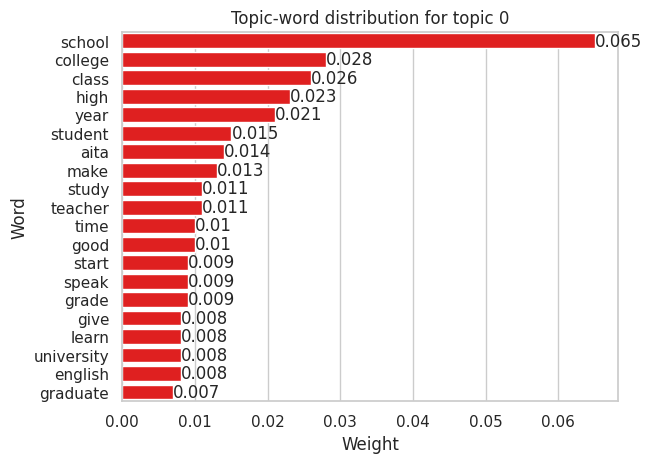

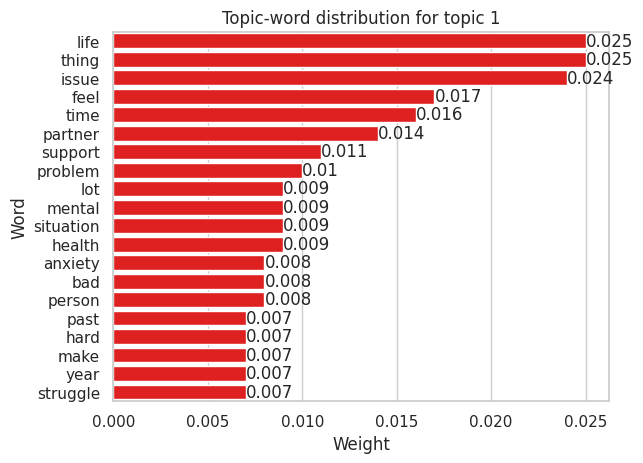

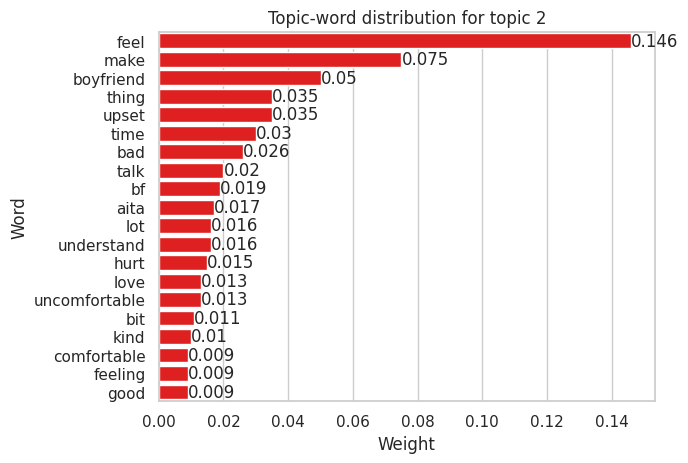

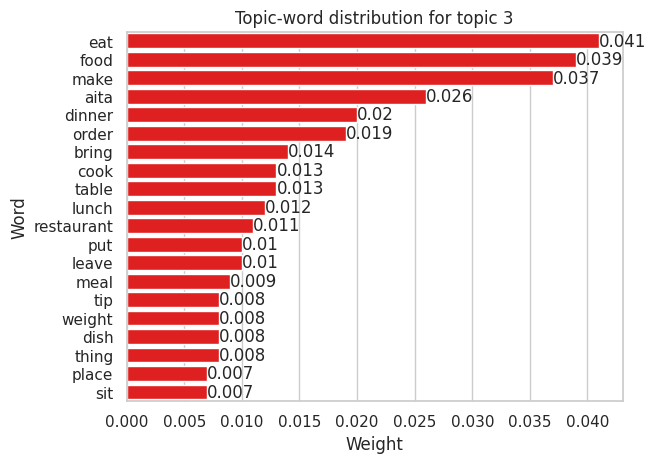

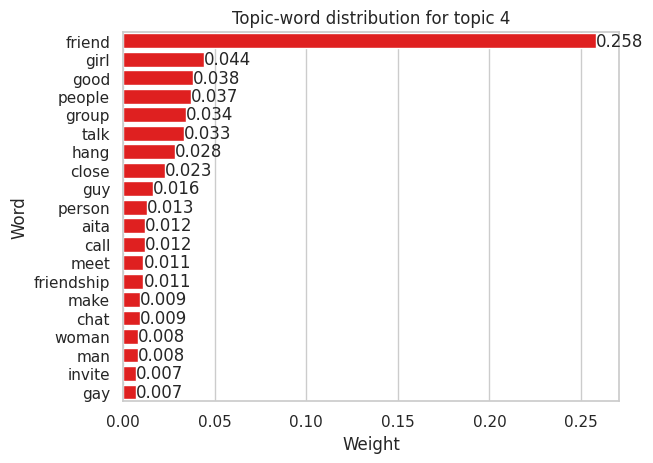

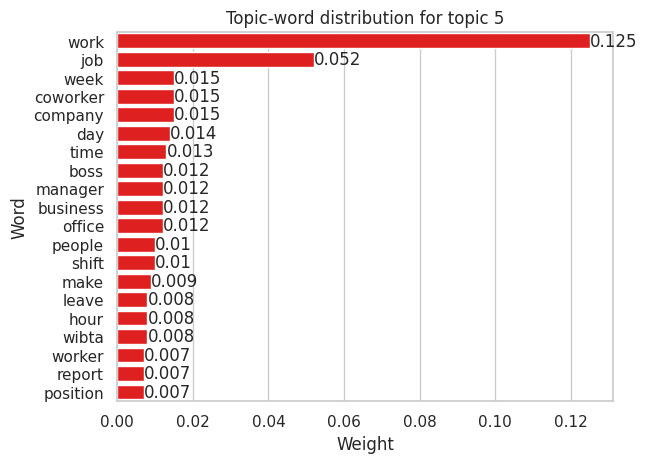

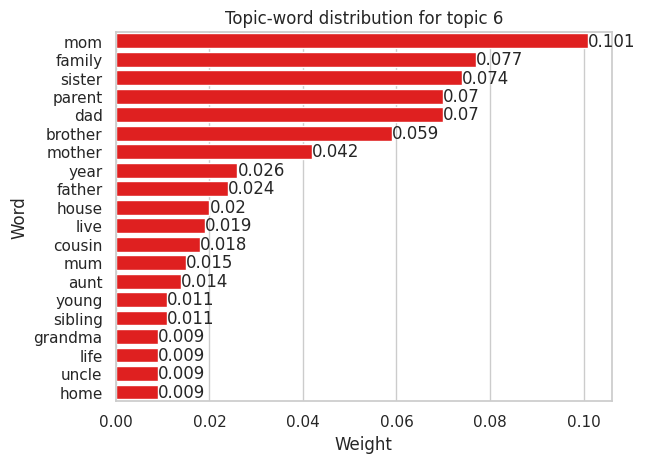

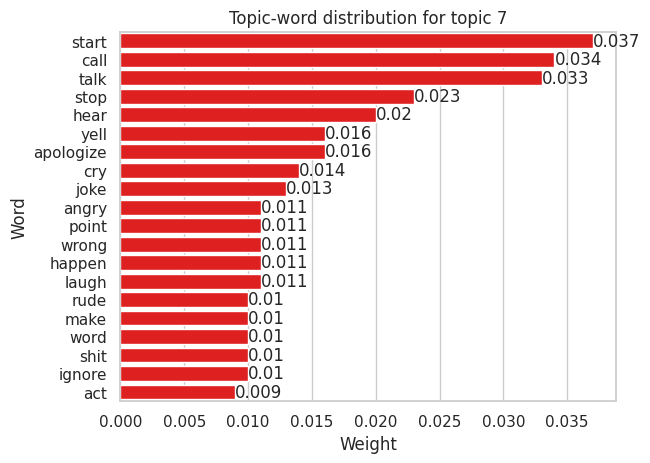

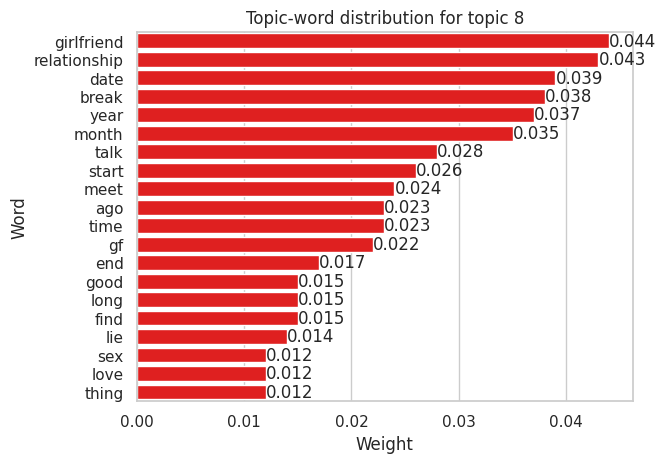

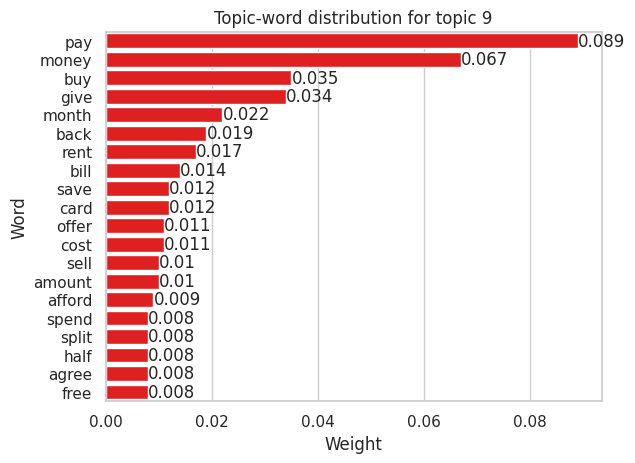

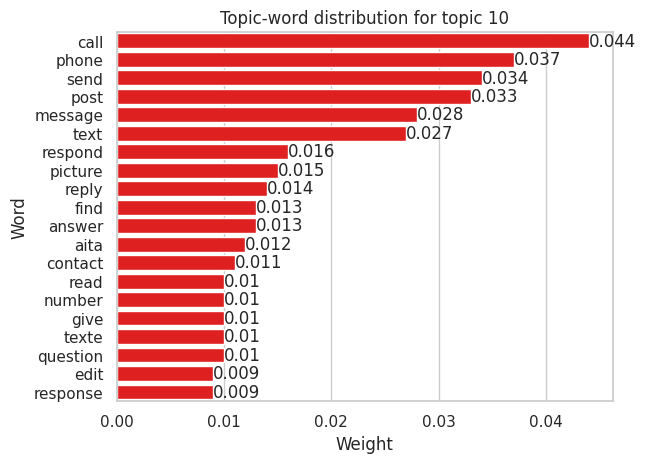

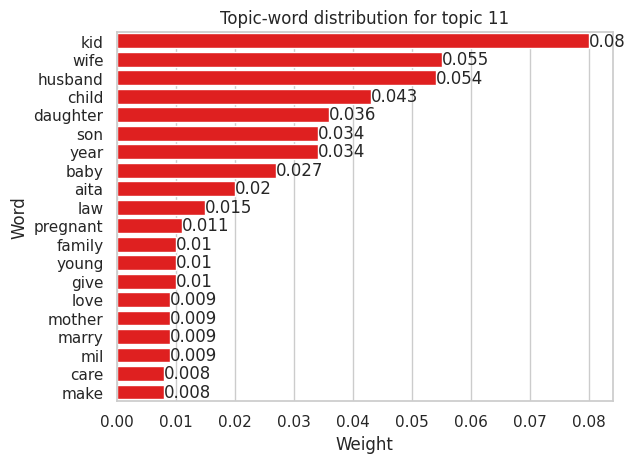

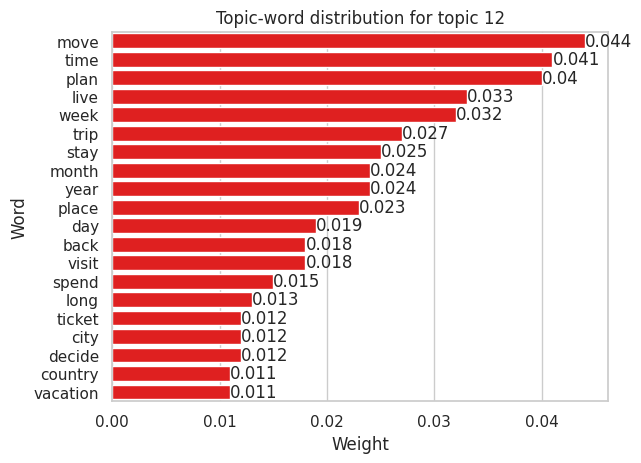

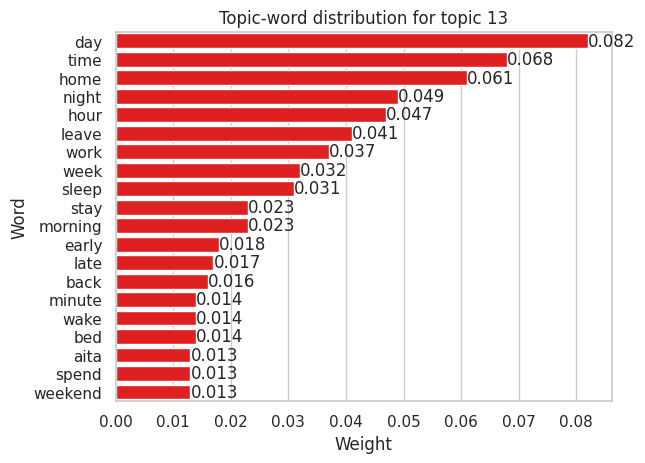

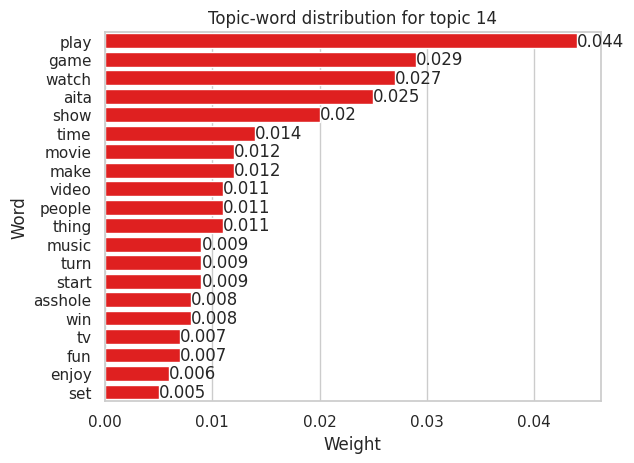

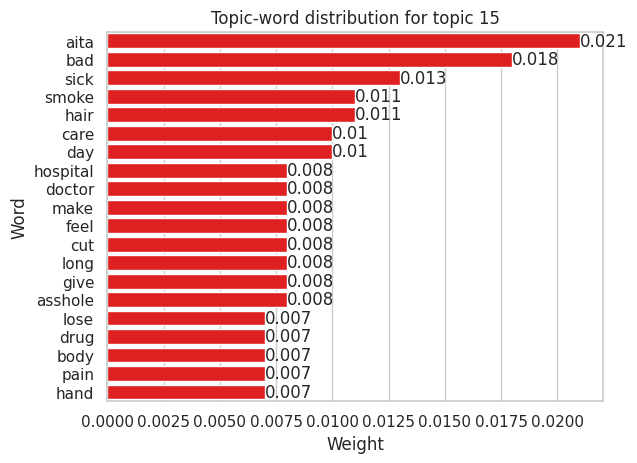

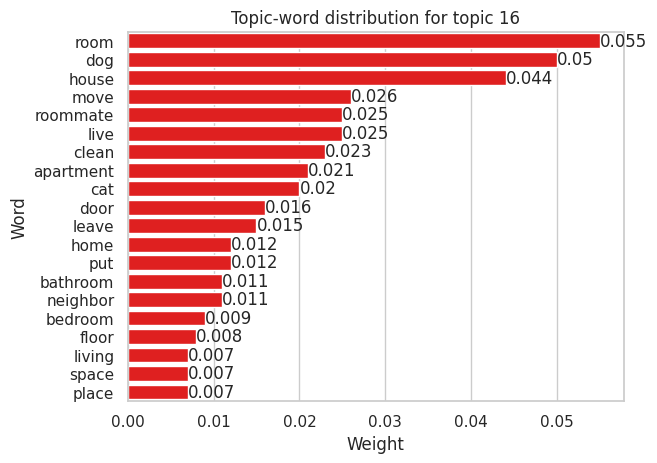

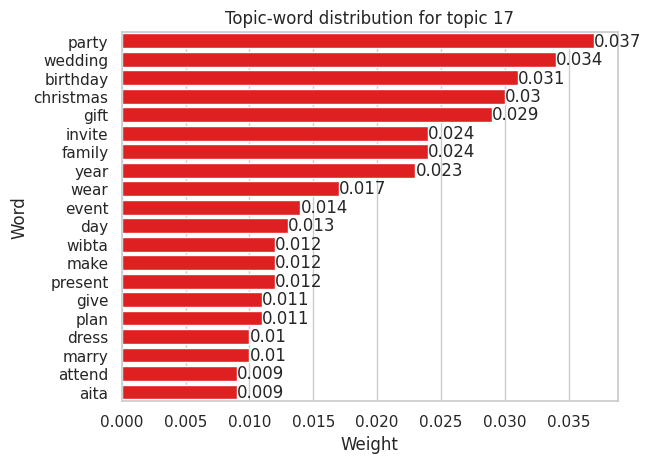

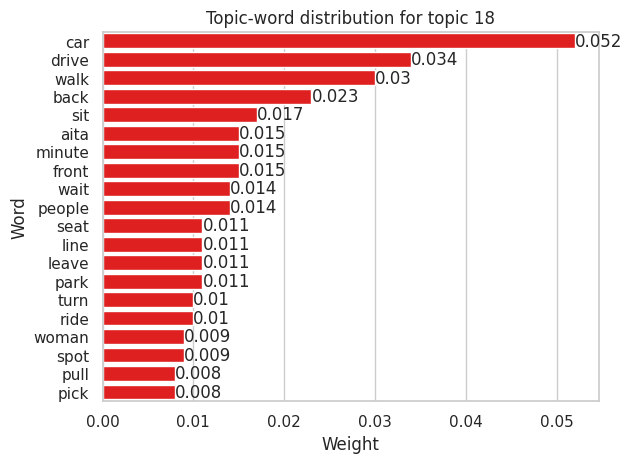

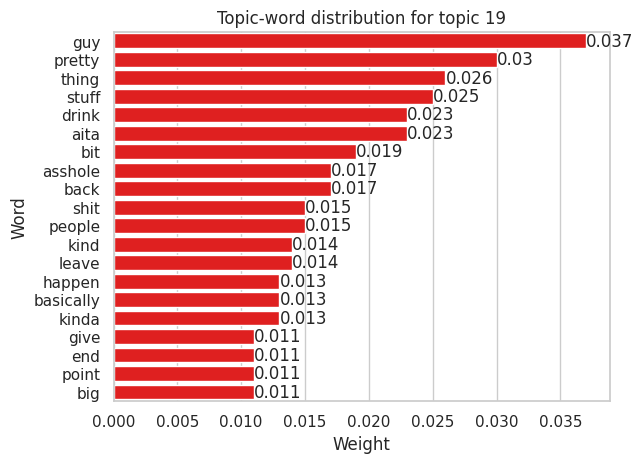

In [ ]:
def plot_topic_word_distribution(topic,i):
  ax = sns.barplot(data=topic, x = "Weight", y="Word", color="red")
  ax.bar_label(ax.containers[0])
  plt.title("Topic-word distribution for topic "+ str(i))
  plt.show()
for i in range(len(topics_weights)):
  topic = pd.DataFrame(topics_weights[i], columns = ["Word","Weight"])
  plot_topic_word_distribution(topic, i)

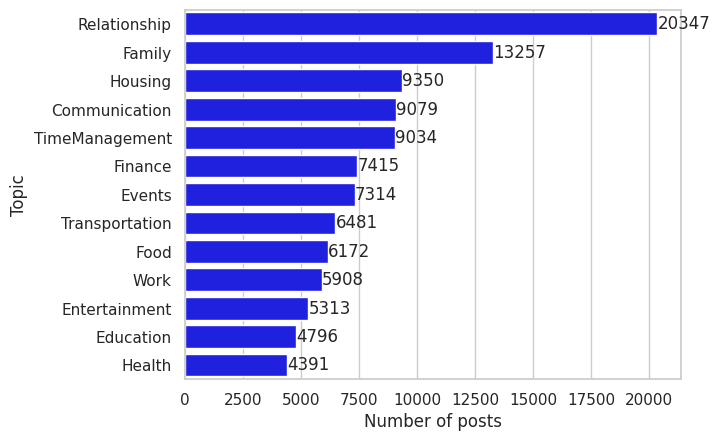

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(y= "Keywords",data = aita_all, color = "blue", order = aita_all["Keywords"].value_counts().index)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Number of posts', ylabel='Topic')
plt.show()

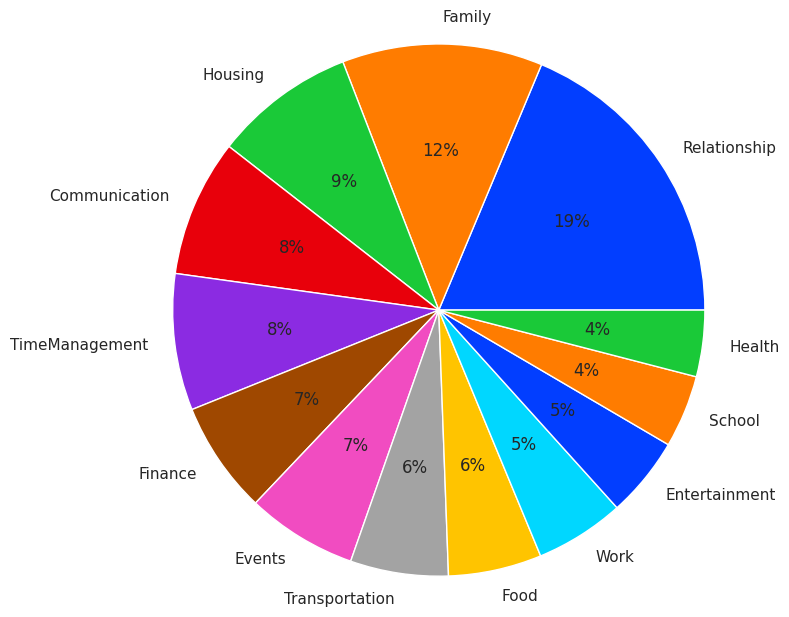

In [ ]:
palette_color = sns.color_palette('bright')
plt.pie(aita_all["Keywords"].value_counts().values, labels = aita_all["Keywords"].value_counts().index, colors = palette_color, autopct='%.0f%%', radius=1.8)
plt.show()

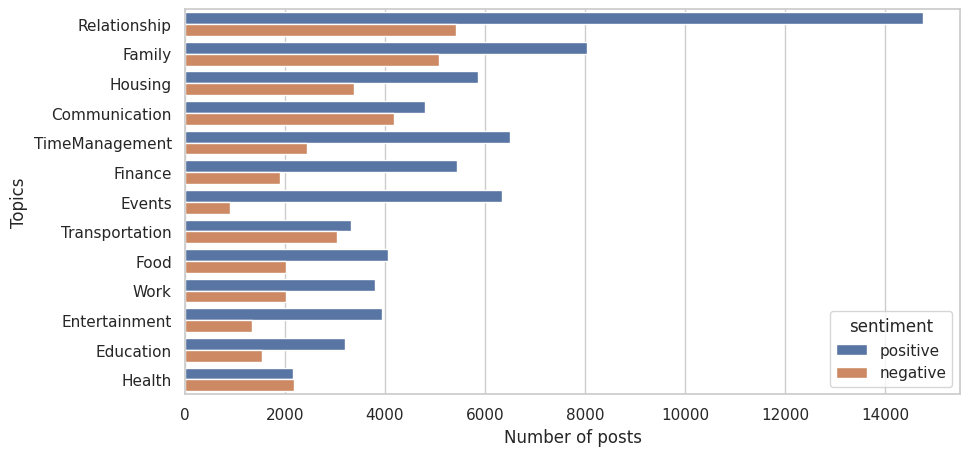

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
ax = sns.countplot(y = "Keywords", data = aita_all[aita_all["sentiment"]!="neutral"], hue="sentiment", order = aita_all["Keywords"].value_counts().index)
ax.set(xlabel='Number of posts', ylabel='Topics')
plt.show()

In [ ]:
aita_all["Percentage_per_"]

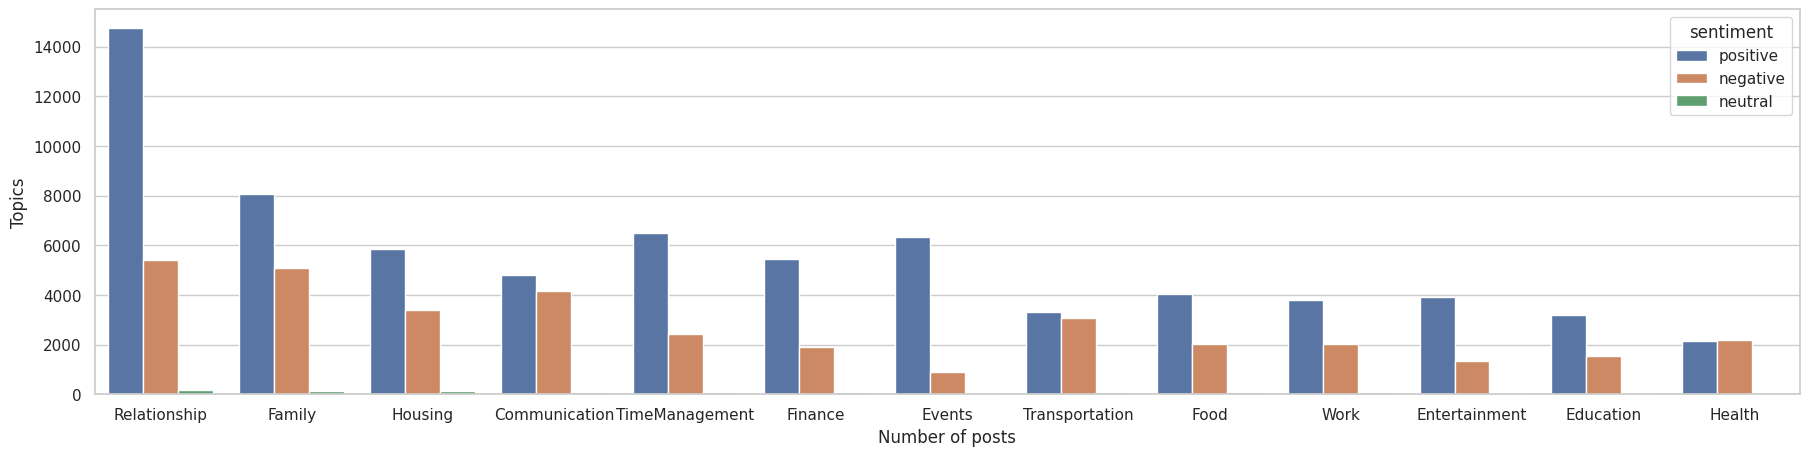

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(22,5))
ax = sns.countplot(x = "Keywords", data = aita_all, hue="sentiment", order = aita_all["Keywords"].value_counts().index)
patches = ax.patches
ax.set(xlabel='Number of posts', ylabel='Topics')
plt.show()


In [ ]:
pd.crosstab(aita_all.Keywords, aita_all.sentiment)

sentiment,negative,neutral,positive
Keywords,,,
Communication,4176,101,4802
Education,1535,66,3195
Entertainment,1331,50,3932
Events,907,70,6337
Family,5074,133,8050
Finance,1893,82,5440
Food,2012,106,4054
Health,2176,59,2156
Housing,3375,122,5853


Text(0, 0.5, 'Percentage distribution over verdicts')

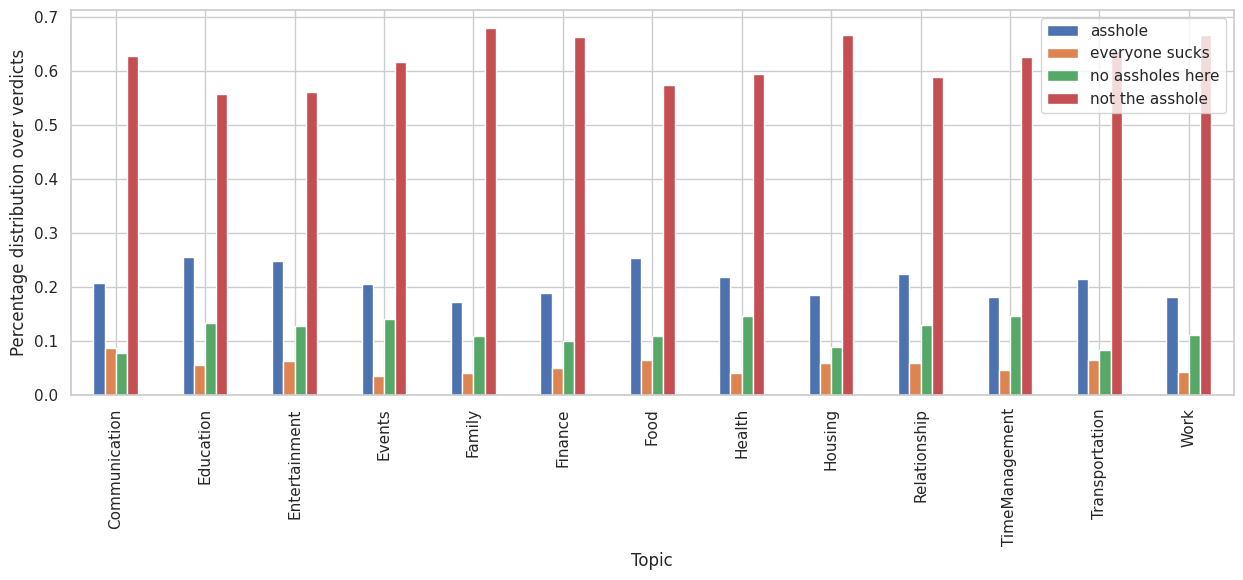

In [ ]:
pd.crosstab(aita_all.Keywords, aita_all.verdict,normalize = "index").plot(kind = "bar",figsize = (15,5)).legend(loc='best')
plt.xlabel("Topic")
plt.ylabel("Percentage distribution over verdicts")

Text(0, 0.5, 'Percentage distribution over sentiments')

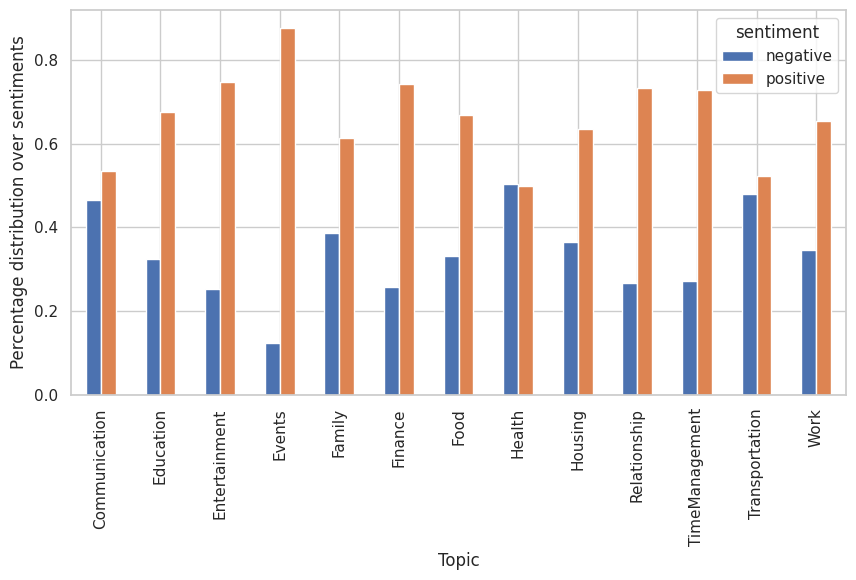

In [ ]:
pd.crosstab(aita_all[aita_all["sentiment"]!="neutral"].Keywords, aita_all[aita_all["sentiment"]!="neutral"].sentiment,normalize = "index").plot(kind = "bar",figsize = (10,5))
plt.xlabel("Topic")
plt.ylabel("Percentage distribution over sentiments")